## SESSION 4: EVALUATION

SO Basics of Neural Networks 2025 school at the IAA-CSIC. Oct 2025.  
Eduardo Sánchez Karhunen (fesanchez@us.es)  
Dept. of CS and Artificial Intelligence. University of Seville. Spain.

### 1. Introduction


In this session, we will tackle two critical concepts simultaneously: **model evaluation** and **class imbalance**. We'll demonstrate that standard metrics like accuracy can be dangerously misleading, especially when dealing with imbalanced datasets: a common scenario in scientific research.

Our workflow will be a story in three parts:

* The problem: We will create an imbalanced dataset and show how even a robust model fails to learn properly.

* The diagnosis: We will pause to introduce advanced evaluation metrics (Precision, Recall, ROC/AUC) to correctly diagnose why the model failed.

* The solutions: We will systematically apply and evaluate three powerful techniques to solve the imbalance problem, comparing then with a final, more advanced metric: the ROC/AUC curve.



### 1. Setup & Data Preparation

First, we'll import all necessary libraries and download the cats and dogs dataset.

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import img_to_array, load_img
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns


In [2]:
SEED = 42
tf.keras.utils.set_random_seed(SEED)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

--2025-10-16 23:56:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   260MB/s    in 0.3s    

2025-10-16 23:56:38 (260 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



### 3. The Problem: Creating en Imbalanced Dataset

Remember the original Dogs&Cats dataset contained 2K training images and 1K valid images splitted into two balanced classes.

In [4]:
print(f"training cat images: {len(os.listdir(train_cats_dir))}")
print(f"training dog images: {len(os.listdir(train_dogs_dir))}")
print(f"validation cat: {len(os.listdir(validation_cats_dir))}")
print(f"validation dog: {len(os.listdir(validation_dogs_dir))}")

training cat images: 1000
training dog images: 1000
validation cat: 500
validation dog: 500


To simulate a realistic problem, we will make the 'cats' class a rare event. We'll do this by removing 80% of the cat images from our training set, creating a 10:2 imbalance in favor of dogs.



In [5]:
cat_files_to_remove = os.listdir(train_cats_dir)
num_cats_to_keep = int(len(cat_files_to_remove) * 0.2)
cats_to_delete = cat_files_to_remove[num_cats_to_keep:]

for filename in cats_to_delete:
    os.remove(os.path.join(train_cats_dir, filename))

print(f"Training cat images: {len(os.listdir(train_cats_dir))}")
print(f"Training dog images: {len(os.listdir(train_dogs_dir))}")

Training cat images: 200
Training dog images: 1000


### 4. Baseline: When a Good Model Fails

We'll use a strong model architecture with Data Augmentation and Dropout. The goal is to show that even these powerful regularization techniques are not enough to overcome a severe class imbalance.

Let's consider the three stage CNN of the previous session with:

1.   16 kernels -> 32 kernels -> 64 kernels
2.   Kernel size = 3x3.
3.   Default stride and padding (stride=1, no-padding).
4.   Pooling 2x2 with default stride (stride=2).
5.   Limit image size to 150 x 150.

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model

Defining the model

In [7]:
def create_model():
  img_input = layers.Input(shape=(150, 150, 3))
  x = layers.Conv2D(16, 3, activation='relu')(img_input)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(32, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(64, 3, activation='relu')(x)
  x = layers.MaxPooling2D(2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  output = layers.Dense(1, activation='sigmoid')(x)

  model = Model(img_input, output)
  return model

Let's create the generators to the train and validation datasets with augmentation rules. Remember validation data should never be augmented, only rescaled.

In [8]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator_imbalanced = train_datagen_augmented.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        shuffle=False,
        class_mode='binary')

Found 1200 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_generator_imbalanced.class_indices

{'cats': 0, 'dogs': 1}

In [11]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

Training and Evaluationg the Baseline Model

In [12]:
baseline_model = create_model()
baseline_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['acc'])

If we do not indicate `steps_per_epoch` and `validation_steps`. In standard generators, Keras extract the batchsize from the generator and adequates de steps the num of samples (although) we are augmenting..

In [13]:
baseline_history = baseline_model.fit(
      train_generator_imbalanced,
      epochs=30,
      validation_data=validation_generator,
      callbacks=[es_callback])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - acc: 0.8029 - loss: 0.5496 - val_acc: 0.5000 - val_loss: 0.9804
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - acc: 0.8392 - loss: 0.4368 - val_acc: 0.5000 - val_loss: 1.2326
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - acc: 0.8096 - loss: 0.5026 - val_acc: 0.5000 - val_loss: 1.0421
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - acc: 0.8180 - loss: 0.4610 - val_acc: 0.5000 - val_loss: 0.8988
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 179ms/step - acc: 0.8281 - loss: 0.4443 - val_acc: 0.5000 - val_loss: 0.8004
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - acc: 0.8460 - loss: 0.4590 - val_acc: 0.5000 - val_loss: 1.0736
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - acc: 0.8226 - loss: 0.4662 - val_acc: 0.5000 - val_loss: 0.8693
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - acc: 0.8400 - loss: 0.4393 - val_acc: 0.5000 - val_loss: 0.8456
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step 

Notice the training log. The acc on the training data is high (~84%), but the val_acc on the balanced validation set is stuck around 50%. This is the accuracy paradox in action. The model has learned the lazy shortcut: "always predict dog."


### 5. Diagnosis: Moving Beyond Accuracy

The baseline model is a failure, but its failure is instructive. It forces us to use better evaluation tools. With the **confusion matrix** we can visualize exactly what the model is doing.

In [14]:
Y_pred_baseline = baseline_model.predict(validation_generator, steps=50)
y_pred_baseline_classes = (Y_pred_baseline > 0.5).astype(int)
y_true = validation_generator.classes

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


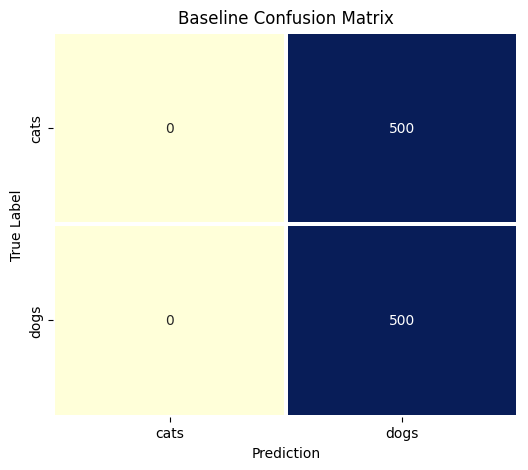

In [15]:
cm_baseline = confusion_matrix(y_true, y_pred_baseline_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cbar=False,
            xticklabels=['cats', 'dogs'], yticklabels=['cats', 'dogs'],
            linewidths=1.5, linecolor='white', cmap="YlGnBu")
plt.title('Baseline Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('True Label');

### 8. Tackle Imbalance: Class Weights

This is the first and often simplest method to combat class imbalance. The core idea is to modify the loss function to penalize mistakes on the minority class more heavily than mistakes on the majority class. In summary, we'll tell the model that a mistake on a cat is much "more expensive" than a mistake on a dog.

Instead of using weights that are strictly inversely proportional to the class frequencies, which can be very aggressive, we will use a smoother, logarithmic scale. This still gives a higher penalty for misclassifying the rare class ('cats') but reduces the risk of the model overcorrecting and starting to ignore the majority class ('dogs').



In [16]:
#weight_for_0 = (1 / 100) * (1100 / 2.0)  # 'cats' (class 0)
#weight_for_1 = (1 / 1000) * (1100 / 2.0) # 'dogs' (class 1)

num_cats = len(os.listdir(train_cats_dir))
num_dogs = len(os.listdir(train_dogs_dir))
total_samples = num_cats + num_dogs

weight_for_0 = np.log(total_samples / num_cats) # Weight for 'cats'
weight_for_1 = np.log(total_samples / num_dogs) # Weight for 'dogs'

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Smoothed weight for cats: {class_weight[0]:.2f}")
print(f"Smoothed weight for dogs: {class_weight[1]:.2f}")

Smoothed weight for cats: 1.79
Smoothed weight for dogs: 0.18


In [17]:
class_weight = {0: 1.1, 1: 0.2}

In [18]:
weighted_model = create_model()
weighted_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['acc'])

es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

weighted_history = weighted_model.fit(
      train_generator_imbalanced,
      epochs=30,
      validation_data=validation_generator,
      class_weight=class_weight,
      callbacks=[es_callback])

Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - acc: 0.6018 - loss: 0.4600 - val_acc: 0.5000 - val_loss: 0.6934
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - acc: 0.2085 - loss: 0.2438 - val_acc: 0.5030 - val_loss: 0.6937
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - acc: 0.1709 - loss: 0.2358 - val_acc: 0.5000 - val_loss: 0.6940
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - acc: 0.1566 - loss: 0.2365 - val_acc: 0.5000 - val_loss: 0.6936
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - acc: 0.1758 - loss: 0.2477 - val_acc: 0.5000 - val_loss: 0.6937


 Le's analyze he confusion matrix of the trained model.

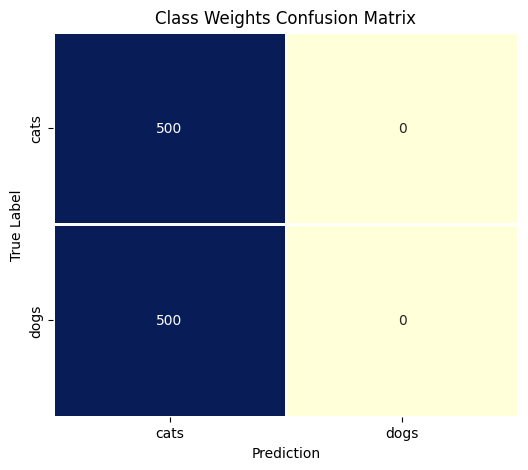

In [19]:
Y_pred_weighted = weighted_model.predict(validation_generator, steps=50, verbose=0)
y_pred_weighted = (Y_pred_weighted > 0.5).astype(int)

cm_weighted = confusion_matrix(y_true, y_pred_weighted)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_weighted,
            annot=True,
            fmt='d',
            cmap="YlGnBu",
            cbar=False,
            linewidths=2,
            linecolor='white',
            xticklabels=['cats', 'dogs'],
            yticklabels=['cats', 'dogs'])
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Class Weights Confusion Matrix');


By applying class weights, we told the model: "Missing a cat (a False Negative) is a terrible mistake." The degree of terrible depends on the assigned weights.

The model has became so afraid of misclassifying the rare 'cats' that it adopted a new cautious strategy: "When in doubt, just predict 'cat'." Looking at the numbers:

 * True Cats (Top Row): The model is now an excellent cat spotter. It correctly identifies almost every single real cat it sees.

 * True Dogs (Bottom Row): Because the model is so aggressive about finding cats, it incorrectly labels a large number of dogs as cats.

 In short, you have successfully trained a model that thinks: "It's better to accidentally call a dog a cat than it is to risk missing a single real cat."


In [20]:
print(classification_report(y_true, y_pred_weighted, target_names=['cats','dogs']))

              precision    recall  f1-score   support

        cats       0.50      1.00      0.67       500
        dogs       0.00      0.00      0.00       500

    accuracy                           0.50      1000
   macro avg       0.25      0.50      0.33      1000
weighted avg       0.25      0.50      0.33      1000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Making sense of the Confusion Matrix

That last result, where the model started calling almost everything a 'cat', is called **The Precision-Recall Trade-off**.

Let's define our terms using "cat" as the class we want to find (the "1" class):

* **True Positive (TP):** The model correctly predicts 'cat'.

* **True Negative (TN):** The model correctly predicts 'dog'.

* **False Positive (FP):** This is a "false alarm". The model incorrectly predicts 'cat'. (It was a dog). "

* **False Negative (FN):** This is a "miss.". The model incorrectly predicts 'dog'. (It was a cat).

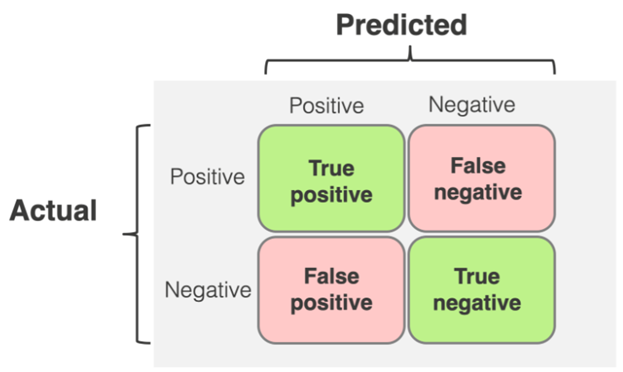

With these values, we can calculate the metrics that truly matter:

**Accuracy**
* Question: Overall, what fraction of predictions were correct?

* $Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{TP + TN}{Total}$


* Insight: The obtained accuracy score (approx. 60%), but it completely hides the model's extreme bias.

**Precision (for Cats)**
* Question: When the model predicts 'cat', how often is it right?

* $Precision = \frac{TP}{TP + FP} \approx 55\%$

* Insight: The model's "cat" predictions are only right less than two-thirds of the time. This low precision is because it raises too many **false alarms**.

**Recall (for Cats)**
* Question: Of all the real cats that exist, how many did the model find?

* $Recall = \frac{TP}{TP + FN} \approx 95\%$

* Insight: The model is fantastic at finding cats! Its high recall shows it missed very few.

The model responded by becoming extremely sensitive, leading to high recall but low precision. It learned that it's "cheaper" to have many false alarms (low precision) than to miss any real cats (high recall). This is a classic trade-off, and understanding it is key to evaluating any classification model.





Truffle Hunter:

* **Precision:** If a truffle dog indicates several spots where there might be truffles, precision would be the proportion of those spots where it actually found a truffle. If it says "there's a truffle here" 10 times and gets it right in 8 of those instances, its precision is 80\%.

* **Recall:** If there are a total of 100 truffles in the forest, and the dog only led you to 60 of them, its recall would be 60%. That is, of all the truffles that were actually there, how many was it able to find?

The perfect model, does not exists. It is virtually impossible achieve 100% precision and 100% recall simultaneously. There's usually a trade-off:

* **Prioritizing Recall** (e.g., Cancer Detection): missing a true positive (a "false negative") can have severe, life-threatening consequences. Therefore, you'd rather have a higher recall, even if it means generating more "false alarms" (false positives) that require further, perhaps unnecessary, investigation.

* **Prioritizing Precision** (e.g., Oil Exploration): Drilling for oil in the deep ocean is incredibly expensive. If the model predicts oil is present in a location, we want to be very, very sure it's actually there. A false positive (predicting oil where there is none) would lead to immense wasted resources. Missing a few potential oil fields (false negatives, lower recall) might be acceptable if the cost of investigating a false positive is astronomically high.

### Finding a balance: The F1-Score

We need a single score that rewards a model for being good at both. The F1-score provides a single, balanced measure of a model's performance.

* $F_1\text{-score} = 2 * \frac{Precision \cdot Recall}{Precision + Recall}$

The way of defining this metric, using the harmonic mean punishes extreme values:

* If precision is 1.0, but recall is 0.1, the simple average is 0.55 (which looks ok).
* However, the F1-score is only 0.18 (which is bad, as it should be).



### 9. Tackle Imbalance with upsampling with massive augmentation

Instead of adjusting the loss function, we fixeds the data itself. The idea is to create a generator that provides a balanced view of the data to the model in every single batch.

This method prevents the model from ever becoming biased, as it never sees an imbalanced dataset.

We will create two separate data streams: one for the minority class ('cats') and one for the majority class ('dogs'). For every batch, we will draw an equal number of images from each stream and combine them. The 'cats' stream will use the same aggressive data augmentation we defined earlier to ensure the model sees many different variations of the few original cat images.


In [21]:
# Only generate cats
cat_generator = train_datagen_augmented.flow_from_directory(
    train_dir,
    classes=['cats'],
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')

# Only generate dogs
dog_generator = train_datagen_augmented.flow_from_directory(
    train_dir,
    classes=['dogs'], #
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')

Found 200 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


This function pulls one batch from the cat generator and one from the dog generator and combines them into a single, perfectly balanced batch. When a generator reads from folder assigns tha numbers to classes in alphabetical order. In this case, as both generator read only one subfolder, they all assign zero to cats and dogs. So, I change it manually dogs to one.

In [22]:
def combined_generator(cat_gen, dog_gen):
    while True:
        cat_x, cat_y = next(cat_gen)
        dog_x, dog_y = next(dog_gen)
        yield np.concatenate([cat_x, dog_x]), np.concatenate([cat_y, np.ones_like(dog_y)])

train_generator_upsampled = combined_generator(cat_generator, dog_generator)


I have defined a custom generator, so I must indicate the 'steps_per_epoch' parameter.

* num_cats_train = 200
* num_dogs_train = 1000
* batch_sizes = 10
* combined_batch_size = 20
* effective_balanced_samples = max(num_cats_train,num_gods_train)x2 = max(200,1000)x2 = 2000
* steps_per_epoch = math.ceil(effective_balanced_samples/combined_batch_size)


In [23]:
import math

num_cats_train = cat_generator.samples
num_dogs_train = dog_generator.samples
batch_size = 10
combined_batch_size = batch_size*2
effective_balanced_samples = max(num_cats_train, num_dogs_train) * 2
steps_per_epoch = math.ceil(effective_balanced_samples // combined_batch_size)

steps_per_epoch

100

In [24]:
upsampled_model = create_model()

upsampled_model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['acc'])

es_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)

upsampled_history = upsampled_model.fit(
      train_generator_upsampled,
      steps_per_epoch=steps_per_epoch,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[es_callback],
      verbose=2)

Epoch 1/30
100/100 - 18s - 179ms/step - acc: 0.5725 - loss: 0.6928 - val_acc: 0.6730 - val_loss: 0.6076
Epoch 2/30
100/100 - 14s - 140ms/step - acc: 0.6270 - loss: 0.6435 - val_acc: 0.6790 - val_loss: 0.6248
Epoch 3/30
100/100 - 14s - 140ms/step - acc: 0.6675 - loss: 0.6187 - val_acc: 0.5920 - val_loss: 0.6682
Epoch 4/30
100/100 - 14s - 137ms/step - acc: 0.6560 - loss: 0.6149 - val_acc: 0.6960 - val_loss: 0.5993
Epoch 5/30
100/100 - 14s - 144ms/step - acc: 0.6845 - loss: 0.6017 - val_acc: 0.6800 - val_loss: 0.5855
Epoch 6/30
100/100 - 13s - 134ms/step - acc: 0.6935 - loss: 0.5813 - val_acc: 0.6940 - val_loss: 0.5691
Epoch 7/30
100/100 - 13s - 133ms/step - acc: 0.7245 - loss: 0.5525 - val_acc: 0.6780 - val_loss: 0.5821
Epoch 8/30
100/100 - 13s - 132ms/step - acc: 0.7175 - loss: 0.5525 - val_acc: 0.7050 - val_loss: 0.5696
Epoch 9/30
100/100 - 14s - 139ms/step - acc: 0.7355 - loss: 0.5271 - val_acc: 0.7170 - val_loss: 0.5585
Epoch 10/30
100/100 - 13s - 133ms/step - acc: 0.7265 - loss: 0.5

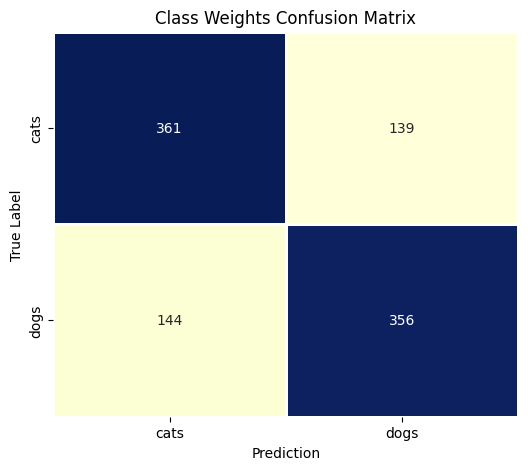

In [25]:
Y_pred_upsampled = upsampled_model.predict(validation_generator, steps=50, verbose=0)
y_pred_upsampled = (Y_pred_upsampled > 0.5).astype(int)

cm_upsampled = confusion_matrix(y_true, y_pred_upsampled)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_upsampled,
            annot=True,
            fmt='d',
            cmap="YlGnBu",
            cbar=False,
            linewidths=2,
            linecolor='white',
            xticklabels=['cats', 'dogs'],
            yticklabels=['cats', 'dogs'])
plt.xlabel('Prediction')
plt.ylabel('True Label')
plt.title('Class Weights Confusion Matrix');

In [26]:
print(classification_report(y_true, y_pred_upsampled, target_names=['cats','dogs']))

              precision    recall  f1-score   support

        cats       0.71      0.72      0.72       500
        dogs       0.72      0.71      0.72       500

    accuracy                           0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000



### 6. AUC - ROC Curve

We've seen that changing class weights drastically changes our model's behavior, creating a trade-off between catching cats (True Positives) and accidentally flagging dogs (False Positives). But which model is truly better? To answer this, we need a metric that summarizes this trade-off.

This is where the Receiver Operating Characteristic (ROC) curve comes in. The ROC curve plots the True Positive Rate (another name for Recall) against the False Positive Rate at every possible decision threshold.

* False Positive Rate (FPR): FP / (FP + TN) - What proportion of dogs were incorrectly classified as cats?

* True Positive Rate (TPR): TP / (TP + FN) - What proportion of cats were correctly identified? (This is just Recall)

How to Read It:

* The "Dummy" Classifier: The diagonal dashed line represents a model that is no better than random guessing.

* The "Perfect" Classifier: A perfect model would have a curve that goes straight up to the top-left corner (100% True Positive Rate with 0% False Positive Rate).

Our Goal: We want our curve to be as far "north-west" of the random-guessing line as possible.

The Area Under the Curve (AUC) gives us a single number to summarize the curve's performance.

* AUC = 1.0: A perfect classifier.

* AUC = 0.5: A useless classifier (random guessing).

* AUC > 0.7: Generally considered an acceptable model.

* AUC > 0.8: Generally considered a good model.

The AUC score is great because it measures the model's ability to distinguish between classes, regardless of the specific classification threshold chosen.

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


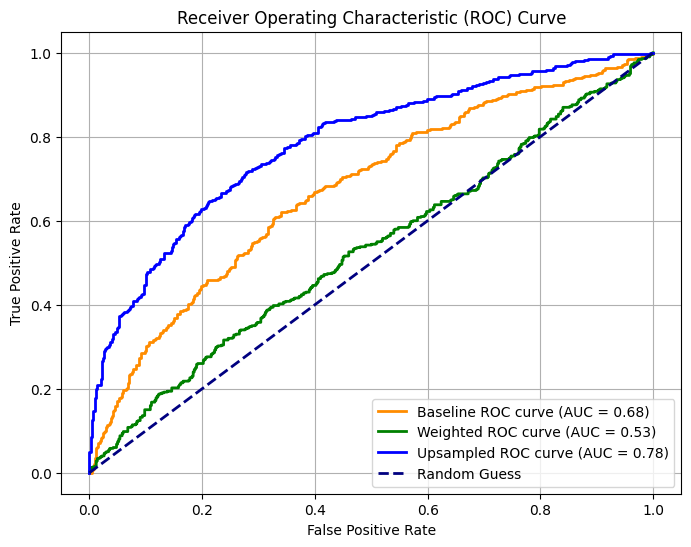

In [27]:
from sklearn.metrics import roc_curve, auc

y_pred_baseline_probs = baseline_model.predict(validation_generator, steps=50)
y_pred_weighted_probs = weighted_model.predict(validation_generator, steps=50)
y_pred_upsampled_probs = upsampled_model.predict(validation_generator, steps=50)

y_true = validation_generator.classes

fpr_base, tpr_base, _ = roc_curve(y_true, y_pred_baseline_probs)
auc_base = auc(fpr_base, tpr_base)

fpr_w, tpr_w, _ = roc_curve(y_true, y_pred_weighted_probs)
auc_w = auc(fpr_w, tpr_w)

fpr_u, tpr_u, _ = roc_curve(y_true, y_pred_upsampled_probs)
auc_u = auc(fpr_u, tpr_u)

# Plot the curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2,
         label=f'Baseline ROC curve (AUC = {auc_base:.2f})')
plt.plot(fpr_w, tpr_w, color='green', lw=2,
         label=f'Weighted ROC curve (AUC = {auc_w:.2f})')
plt.plot(fpr_u, tpr_u, color='blue', lw=2,
         label=f'Upsampled ROC curve (AUC = {auc_u:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


